<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Information-Criteria" data-toc-modified-id="Information-Criteria-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Information Criteria</a></span><ul class="toc-item"><li><span><a href="#Exercise:-Use-the-BIC-to-determine-the-optimum-number-of-evenly-spaced-Gaussians-for-the-spectra" data-toc-modified-id="Exercise:-Use-the-BIC-to-determine-the-optimum-number-of-evenly-spaced-Gaussians-for-the-spectra-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Exercise: Use the BIC to determine the optimum number of evenly-spaced Gaussians for the spectra</a></span></li></ul></li><li><span><a href="#Regularization" data-toc-modified-id="Regularization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regularization</a></span><ul class="toc-item"><li><span><a href="#Discussion:-Why-is-the-&quot;smoothness&quot;-of-a-model-related-to-the-size-of-its-parameters?" data-toc-modified-id="Discussion:-Why-is-the-&quot;smoothness&quot;-of-a-model-related-to-the-size-of-its-parameters?-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Discussion: Why is the "smoothness" of a model related to the size of its parameters?</a></span></li><li><span><a href="#Discussion:-What-happens-as--$\alpha-\rightarrow$-0-and-$\alpha-\rightarrow$-$\infty$?" data-toc-modified-id="Discussion:-What-happens-as--$\alpha-\rightarrow$-0-and-$\alpha-\rightarrow$-$\infty$?-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Discussion: What happens as  $\alpha \rightarrow$ 0 and $\alpha \rightarrow$ $\infty$?</a></span></li><li><span><a href="#Exercise:-Use-cross-validation-to-determine-the-optimal-value-of-$\alpha$-when-$\sigma=20$." data-toc-modified-id="Exercise:-Use-cross-validation-to-determine-the-optimal-value-of-$\alpha$-when-$\sigma=20$.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Exercise: Use cross validation to determine the optimal value of $\alpha$ when $\sigma=20$.</a></span></li></ul></li><li><span><a href="#LASSO-Regularization" data-toc-modified-id="LASSO-Regularization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LASSO Regularization</a></span></li><li><span><a href="#Hyperparameter-Tuning" data-toc-modified-id="Hyperparameter-Tuning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hyperparameter Tuning</a></span><ul class="toc-item"><li><span><a href="#Exercise:-Optimize-the-hyperparameters-of-a-LASSO-model-for-the-spectrum-data" data-toc-modified-id="Exercise:-Optimize-the-hyperparameters-of-a-LASSO-model-for-the-spectrum-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Exercise: Optimize the hyperparameters of a LASSO model for the spectrum data</a></span></li></ul></li></ul></div>

# Complexity Optimization

The key to machine learning is creating models that generalize to new examples. This means we are looking for models with enough complexity to describe the behavior, but not so much complexity that it just reproduces the data points.

<center>
<img src="images/underfitting_overfitting.png" width="800">
</center>

* Underfitting: The model is just "guessing" at the data, and will be equally bad at the data it has been trained on and the data that it is tested on.

* Overfitting: The model has memorized all of the training data, and will be perfect on training data and terrible on testing data.

* Optimal complexity: The model has *learned* from the training data and can *generalize* to the training data. The performance should be approximately as good for both sets.

Consider the general form of a machine-learning model introduced earlier:

$\vec{y} = f(\vec{x}, \vec{w}(\vec{\eta}))$
 
 The "complexity" of a model is defined by its hyperparameters ($\vec{\eta}$). The goal of machine learning is to **optimize the complexity** of a model so that it **generalizes to new examples**. In order to achieve this goal we first need a way to quantify complexity so that we can optimize it.
 
 In general there are a few strategies:
 
 * Number of parameters: "Complexity" varies linearly with number of parameters
 * Information criteria: "Complexity" varies with number of parameters and is balanced by the model error.
 * "Smoothness": "Complexity" is related to the maximum curvature of the model
 
 "With four parameters I can fit an elephant, and with five I can make him wiggle his trunk."
 
 -- John Von Neumann
 
 (see an [example here](https://www.johndcook.com/blog/2011/06/21/how-to-fit-an-elephant/))

## Information Criteria

The idea behind an "information criterion" is that it quantifies the tradeoff between the number of parameters and the model error. The most commonly used information criterion is the "Bayesian Information Criterion", or BIC. The derivation of the BIC is beyond the scope of this course, but conceptually a lower BIC corresponds to a *more* probable model.

If we assume that our error is normally distributed, the BIC can be easily computed as:

$ BIC = n*\ln{(\sigma^2_e)} + k*\ln(n)$

where $n$ is the number of data points, $\sigma_e$ is the standard deviation of the error, and $k$ is the number of parameters.

There are a few other "information critera", with the Akaike Information Criterion, or AIC, being the other most commonly used. For now we will just consider the BIC, but they typically yield similar optimal models.

Let's implement the BIC in Python:

In [1]:
def BIC(y, yhat, k):
    err = y - yhat
    sigma = np.std(np.real(err))
    n = len(y)
    B = n*np.log(sigma**2) + k*np.log(n)
    return B

Now we will apply it to models with the spectra dataset:

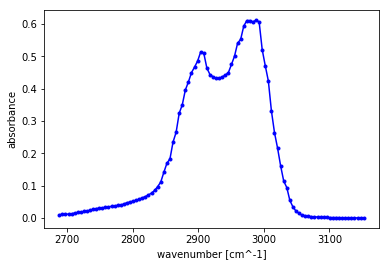

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('data/ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

x_peak = x_all[475:575]
y_peak = y_all[475:575]

fig, ax = plt.subplots()
ax.plot(x_peak,y_peak, '-b', marker='.')
ax.set_xlabel('wavenumber [cm^-1]')
ax.set_ylabel('absorbance');

Now, let's compare some of the many different models we have used for modeling the spectrum from the previous module and this module. We will look at the following models:

* Polynomial regression with 40 polynomials (40 parameters)
* Gaussian regression 20 evenly-spaced Gaussians (20 parameters)

We will re-implement the polynomial and Gaussian regressions using `scikit-learn` to make things easier:

In [3]:
from sklearn.linear_model import LinearRegression

def polynomial_features(x, N):
    # function to return a matrix of polynomials for x to order N
    # One-liner uses "list comprehension" to iterate through range 0 - N (note N+1 since range function is not inclusive)
    # The input, x, is raised to the power of N for each value of N
    # The result is converted to an array and transposed so that columns correspond to features and rows correspond to data points (individual x values)
    return np.array([x**k for k in range(0,N)]).T

N = 40
X_poly = polynomial_features(x_peak, N)

LR_poly = LinearRegression() #create a linear regression model instance
LR_poly.fit(X_poly, y_peak) #fit the model
yhat_poly = LR_poly.predict(X_poly)

BIC_poly = BIC(y_peak, yhat_poly, N)
BIC_poly

-278.8755549227588

In [4]:
def gaussian_features(x, N , sigma = 25):
    # x is a vector
    # sigma is the standard deviation
    xk_vec = np.linspace(min(x), max(x), N)
    features = []
    for xk in xk_vec:
        features.append(np.exp(-((x - xk)**2/(2*sigma**2))))
    return np.array(features).T

N = 20
X_gauss = gaussian_features(x_peak, N)

LR_gauss = LinearRegression() #create a linear regression model instance
LR_gauss.fit(X_gauss, y_peak) #fit the model
yhat_gauss = LR_gauss.predict(X_gauss)

BIC_gauss = BIC(y_peak, yhat_gauss, N)
BIC_gauss

-896.2526132005678

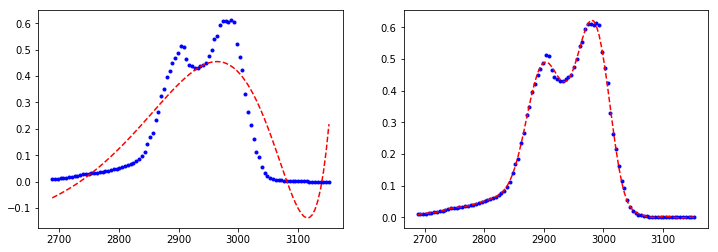

In [5]:
fig, axes = plt.subplots(1,2, figsize = (12,4))
axes[0].plot(x_peak, y_peak, '.b')
axes[1].plot(x_peak, y_peak, '.b')

axes[0].plot(x_peak, yhat_poly, '--r')
axes[1].plot(x_peak, yhat_gauss, '--r');

We can see that the BIC correctly predicts that the Gaussian model is preferred.

### Exercise: Use the BIC to determine the optimum number of evenly-spaced Gaussians for the spectra

There are numerous other "information criteria" that can be used in a similar way. Another common one is the "Aikake information criterion":

$ AIC = 2*(\ln{(\sigma^2_e)} + k)$

This is derived from a slightly different set of statistical assumptions. There are other criteria as well, and you can find them in the statistical literature if needed. However, it can often be very challenging to determine if your dataset fits the assumptions of the criteria, and in practice it is common to just use BIC. However, without knowing the details of the statistical assumptions these are not rigorous and should not be used as a substitute for common sense or intuition. However, the general idea of balancing number of parameters and model error provides a solid framework for thinking about complexity optimization.

One other challenge with information criteria is that non-parametric models have parameters that are not defined in the same way (the parameters and their values change depending on the training data). This makes it difficult (or impossible) to apply information critera with non-parametric models.

## Regularization

Another way of penalizing complexity is by trying to penalize models that change very sharply. This is achieved by adding a penalty for parameters with very large values in the loss function. For example:

$L = \sum_i \epsilon_i^2 + \alpha \sqrt{\sum_j w_j^2}$

In this case, we introduce a new hyperparameter, $\alpha$, which controls the strength of regularization. We also choose to regularize on the square root of the sum of squared parameters, which is often called the "L2 norm" and written as:

$L = \sum_i \epsilon_i^2 + \alpha ||\vec{w}||_2$

We can also regularize in other ways, which can have advantages in some cases. We will discuss this more later, but will focus on the L2 norm for now.

### Discussion: Why is the "smoothness" of a model related to the size of its parameters?

Regularization is especially critical in the case of non-parametric models, where the number of parameters is always greater than the number of data points. If we use a kernel and regularize on the sum of squared parameters it is called **Kernel Ridge Regression**, or KRR. We will not derive the equations here, but it can be done analytically (Hint: You should think about how you would do this).

We will just use the `scikit-learn` implementation for now:

In [6]:
from sklearn.kernel_ridge import KernelRidge
help(KernelRidge)

Help on class KernelRidge in module sklearn.kernel_ridge:

class KernelRidge(sklearn.base.BaseEstimator, sklearn.base.RegressorMixin, sklearn.base.MultiOutputMixin)
 |  Kernel ridge regression.
 |  
 |  Kernel ridge regression (KRR) combines ridge regression (linear least
 |  squares with l2-norm regularization) with the kernel trick. It thus
 |  learns a linear function in the space induced by the respective kernel and
 |  the data. For non-linear kernels, this corresponds to a non-linear
 |  function in the original space.
 |  
 |  The form of the model learned by KRR is identical to support vector
 |  regression (SVR). However, different loss functions are used: KRR uses
 |  squared error loss while support vector regression uses epsilon-insensitive
 |  loss, both combined with l2 regularization. In contrast to SVR, fitting a
 |  KRR model can be done in closed-form and is typically faster for
 |  medium-sized datasets. On the other hand, the learned model is non-sparse
 |  and thus

If we look at the parameters we see that we need to specify which kernel to use (we will use `rbf`), the `gamma` value corresponding to the width of the kernel, and `alpha` corresponding to the regularization strength. You are already familiar with the `rbf` kernel and `gamma` from the non-parametric models lecture. The only new thing here is the regularization strength, `alpha`.

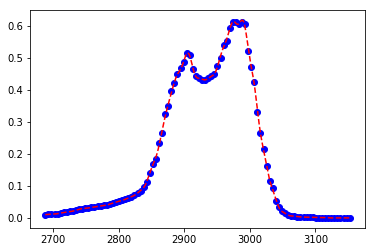

In [7]:
sigma = 10
gamma = 1./(2*sigma**2)

alpha = 0.001

KRR = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
x_peak = x_peak.reshape(-1,1) #we need to convert these to columns
y_peak = y_peak.reshape(-1,1)

KRR.fit(x_peak, y_peak)

x_predict = np.linspace(min(x_peak), max(x_peak), 300) #create prediction data
yhat_KRR = KRR.predict(x_predict)

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, 'ob')
ax.plot(x_predict, yhat_KRR, '--r', markerfacecolor='none');

### Discussion: What happens as  $\alpha \rightarrow$ 0 and $\alpha \rightarrow$ $\infty$?

We see that the regularization clearly affects the model, but sometimes it seems to make it worse. We need some strategy for assessing what value of regularization to choose. We can go back to the idea of cross-validation to achieve this:

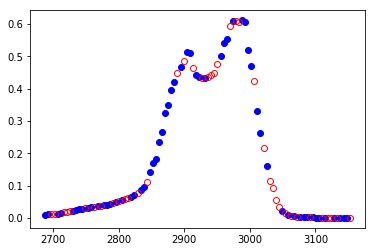

In [8]:
from sklearn.model_selection import train_test_split
np.random.seed(0)

x_train, x_test, y_train, y_test = train_test_split(x_peak, y_peak, test_size=0.4)

fig, ax = plt.subplots()

ax.plot(x_train, y_train, 'ob')
ax.plot(x_test, y_test, 'or', markerfacecolor='none');

We can use hold out to compute the error on the testing data as we vary the regularization strength:

0.9816791895375325


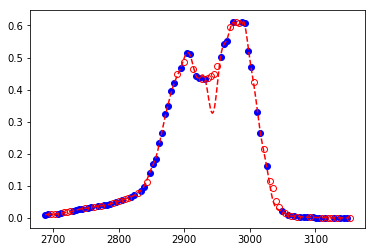

In [9]:
sigma = 10
gamma = 1./(2*sigma**2)

alpha = 1e-3

KRR = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
KRR.fit(x_train, y_train)

x_predict = np.linspace(min(x_peak), max(x_peak), 300) #create prediction data
yhat_KRR = KRR.predict(x_predict)

r2_test = KRR.score(x_test, y_test)
print(r2_test)

fig, ax = plt.subplots()
ax.plot(x_train, y_train, 'ob')
ax.plot(x_test, y_test, 'or', markerfacecolor='none');
ax.plot(x_predict, yhat_KRR, '--r', markerfacecolor='none');

You can also see how the regularization affects the parameters, $\vec{w}$, by looking at the (not intuitively named) `dual_coef_` attribute of the KRR model:

The model has 60 coefficients.
The largest coefficient is 10.984.


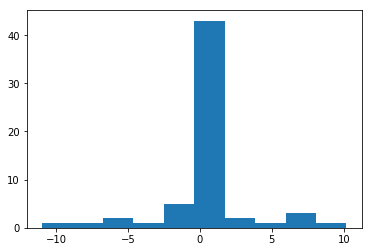

In [10]:
coeffs= KRR.dual_coef_
print('The model has {} coefficients.'.format(len(coeffs)))

fig, ax = plt.subplots()
ax.hist(coeffs)
print('The largest coefficient is {:.3f}.'.format(max(abs(coeffs))[0]));

### Exercise: Use cross validation to determine the optimal value of $\alpha$ when $\sigma=20$.

## LASSO Regularization

Ridge regression provides a good way to penalize model "smoothness", but it doesn't actually reduce the number of parameters. We can see that all of the coefficients are non-zero:

In [11]:
nonzero = [f for f in np.isclose(coeffs,0) if f == False]
print('Total number of non-zero parameters: {}'.format(len(nonzero)))

Total number of non-zero parameters: 60


Ideally we could also use regularization to reduce the number of parameters. It turns out that this can be achieved using the L1 norm:

$||L_1|| = \sum_i |w_i|$

where $|.|$ is the absolute value. This is called "least absolute shrinkage and selection operator" regression, which is a terrible name with a great acronym: LASSO. The loss function for LASSO is defined as:

$L_{LASSO} = \sum_i \epsilon_i^2 + \alpha ||\vec{w}||_1$

This can be compared to the loss function for ridge regression:

$L_{ridge} = \sum_i \epsilon_i^2 + \alpha ||\vec{w}||_2$

We will not go through the derivation of *why* the L1 norm causes parameters to go to zero, but the following schematic, borrowed from [this website](https://niallmartin.wordpress.com/2016/05/12/shrinkage-methods-ridge-and-lasso-regression/) may be useful (note that $\vec{\beta}$ is equivalent to $\vec{w}$:

<center>
<img src="images/lasso_vs_ridge_regression.png" width="600">
</center>

We can also test it using `scikit-learn`. Unfortunately, we need to create our own feature (basis) matrix, $X_{ij}$, similar to linear regression, so we will need a function to evaluate the `rbf`. Instead of using our own, we can use the one from `scikit-learn`:

In [12]:
from sklearn.metrics.pairwise import rbf_kernel

sigma = 10
gamma = 1./(2*sigma**2)

X_train = rbf_kernel(x_train, x_train, gamma=gamma)

60


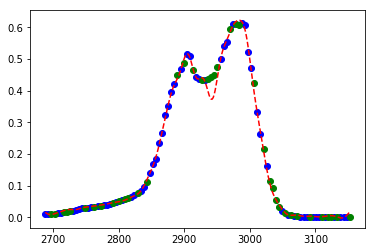

In [13]:
from sklearn.linear_model import Lasso

sigma = 10
gamma = 1./(2*sigma**2)

alpha = 1e-4

LASSO = Lasso(alpha=alpha)
LASSO.fit(X_train, y_train)
print(len(LASSO.coef_))

x_predict = np.linspace(min(x_peak), max(x_peak), 300) #create prediction data
X_predict = rbf_kernel(x_predict, x_train, gamma=gamma)

yhat_LASSO = LASSO.predict(X_predict)

fig, ax = plt.subplots()
ax.plot(x_train, y_train, 'ob')
ax.plot(x_test, y_test, 'og')
ax.plot(x_predict, yhat_LASSO, '--r');

The results look similar to KRR. Now we can see how many non-zero parameters there are, and check the parameter values:

Total number of non-zero parameters: 41


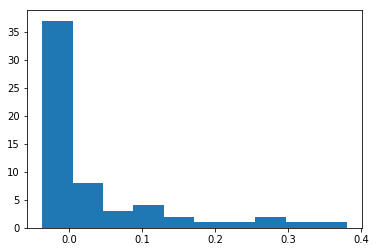

In [14]:
coeffs = LASSO.coef_

fig, ax = plt.subplots()
ax.hist(coeffs)

nonzero = [f for f in np.isclose(coeffs,0) if f == False]
print('Total number of non-zero parameters: {}'.format(len(nonzero)))

We see that the LASSO regularization has a lot of coefficients that are equal to zero. This is equivalent to discarding these terms and finding which Gaussians should (or should not) be included.

## Hyperparameter Tuning

The KRR and LASSO models above have 2 hyperparameters: $\gamma$ $\left(=\frac{1}{2\sigma^2}\right)$ and $\alpha$. So far, we have optimized $\alpha$, but the model performance (and optimal $\alpha$) will also depend on $\sigma$. You can probably see that optimizing these will get rather tedious.

Fortunately, `scikit-learn` has some nice built-in tools to help. The most commonly used is `GridSearchCV`, which is a brute-force approach that searches over a grid of hyperparameters, and uses cross-validation at each grid point to assess model performace.

Here we will use GridSearchCV to find the optimum KRR model and its score (related to $R^2$):

In [15]:
from sklearn.model_selection import GridSearchCV

sigmas = np.array([5, 10, 15, 20, 25, 30,35, 40])
gammas = 1./(2*sigmas**2)

alphas = np.array([1e-9, 1e-5, 1e-4,1e-3, 1e-2,1e-1, 1])

parameter_ranges = {'alpha':alphas, 'gamma':gammas}

KRR = KernelRidge(kernel='rbf')

KRR_search = GridSearchCV(KRR, parameter_ranges, cv=3)
KRR_search.fit(x_train,y_train)
KRR_search.best_estimator_, KRR_search.best_score_

(KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=0.0005555555555555556,
             kernel='rbf', kernel_params=None), 0.9953287405140008)

This tells us that the best performance comes from a model with $\alpha=0.01$ and $\gamma=0.000555$. We can check the performance of the model:

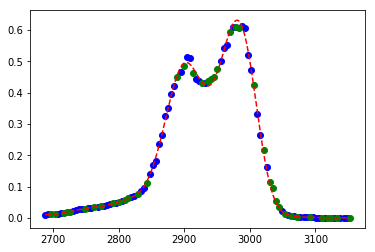

In [16]:
yhat_KRR = KRR_search.best_estimator_.predict(x_predict)

fig, ax = plt.subplots()
ax.plot(x_train, y_train, 'ob')
ax.plot(x_test, y_test, 'og')
ax.plot(x_predict, yhat_KRR, '--r', markerfacecolor='none');

This is much faster than doing all the work yourself!

One note is that the best model will depend on the parameters you search over, as well as the cross-validation strategy. In this case, `cv=3` means that the model performs 3-fold cross-validation at each gridpoint.

### Exercise: Optimize the hyperparameters of a LASSO model for the spectrum data

Search over the same values of $\alpha$ and $\sigma$ as for KRR above, and use 3-fold cross validation.

Note: You will need to use a for loop over the $\sigma$ values. Use `GridSearchCV.best_score_` as accuracy metric.

In [17]:
sigmas = np.array([5,10, 15, 20,25,30,35,40])
gammas = 1./(2*sigmas**2)

alphas = np.array([1e-9, 1e-5, 1e-4, 1e-3, 1e-2,1e-1, 1, 10, 100, 1000])

#insert code here